# Generalized Block Coherence: Connection to the Pseudo Inverse
## Gaussian Case

In [1]:
import cvxpy as cp
import numpy as np
from scipy.linalg import toeplitz, circulant
import numpy as np
import matplotlib.pyplot as plt
import pdb
import numpy.linalg as linalg

np.random.seed(1)

In [2]:
def R(D, n, d):
    n_y, n_x  = D.shape
    R = np.zeros((n,n))
    for k in range(0,n):
      for l in range(k,n):
          I = np.zeros((n_x,n_x))
          I_s = np.zeros((n,n))
          I[l*d:(l+1)*d, k*d:(k+1)*d] = np.ones(d)
          I_s[l,k] = 1 
          if k==l:
            R = R+cp.norm(cp.multiply(I,D), 2)*I_s
          else:
            R = R+cp.norm(cp.multiply(I,D), 2)*I_s+cp.norm(cp.multiply(I.T,D), 2)*I_s.T
        
    return R

In [3]:
def circ(k):
  #pdb.set_trace()
  n = k.shape[0]
  K = np.zeros((n,n))
  T1 = np.zeros((1,n))
  T1[0,-1]=1
  T2 = np.concatenate([np.eye(n-1), np.zeros((n-1,1))], axis=1)
  T = np.concatenate([T1, T2])
  I = np.zeros((n,n))
  ki = k
  I[:,0] = 1
  K = K+np.multiply(ki,I)
  I[:,0] = 0
  for i in range(1,n):
    I[:,i] = 1
    ki = T@ki
    K = K+np.multiply(ki,I)
    I[:,i] = 0

  return K

In [4]:
def cvx_orig_solver(D, m, n, d):
  # Construct the problem.
  B_cvx = cp.Variable((m*d,n*d))

  I = np.kron(np.eye(n), np.ones((d, d)))
  k = np.tile(np.eye(d), (1, n)).T
  b = cp.multiply(B_cvx.T@D, I)
  b = cp.matmul(b, k) #extracting the diagonal blocks of D^TB
  constraints = [b == k]

  objective = cp.Minimize(1/d*cp.max(R(B_cvx.T@D-np.eye(n*d), n, d)))
  if d == 1:
    objective = cp.Minimize(cp.max(cp.abs(B_cvx.T@D-np.eye(n*d))))
  prob = cp.Problem(objective, constraints)

  result = prob.solve()
  return B_cvx

def cvx_fro_solver(D, m, n, d):
  # Construct the problem.
  B_up = cp.Variable((m*d,n*d))

  I = np.kron(np.eye(n), np.ones((d, d)))
  k = np.tile(np.eye(d), (1, n)).T
  b = cp.multiply(B_up.T@D, I)
  b = cp.matmul(b, k) #extracting the diagonal blocks of D^TB
  constraints = [b == k]

  objective = cp.Minimize(1/d*(cp.norm(B_up.T@D, 'fro')))

  #objective = cp.Minimize(cp.max(cp.abs(A.T@x-np.eye(n))))

  prob = cp.Problem(objective, constraints)

  # The optimal objective value is returned by `prob.solve()`.
  result = prob.solve()
  return B_up

def compute_W_Thm(D, n, d):
  W = np.zeros(D.shape)
  m,n = D.shape
  for i in range(0,n):
      #pdb.set_trace()
      K = (2*D@D.T)@(2*D@D.T)+D[:,i * d:(i + 1) * d]@D[:,i * d:(i + 1) * d].T
      K_p = linalg.pinv(K)
      E = 2*D@D.T@D[:,i * d:(i + 1) * d]
      R = D[:,i * d:(i + 1) * d] - 2*D@D.T@K_p@E
      S = - D[:,i * d:(i + 1) * d].T@K_p@E
      L = R.T@R + S.T@S
      I = np.eye((L.T@L).shape[0])
      M = K_p@E@(I - linalg.pinv(L)@L)
      H = linalg.pinv(L)@S.T + (I - linalg.pinv(L)@L)@linalg.inv(I + M.T@M)@(K_p@E).T@K_p@(D[:,i * d:(i + 1) * d]-E@linalg.pinv(L)@S.T)
      W[:,i * d:(i + 1) * d] = K_p@(D[:,i * d:(i + 1) * d]-E@H)
  return W

# Intro

The Notebook is organized as follows:



1.   Case 1: $D\in\mathbb{R}^{m,n}$ with $m<n$ 

    *   $d = 1$, i.e. the sparse case
    *   $d = 4$, i.e. block sparse case

2.   Case 1: $D\in\mathbb{R}^{m,n}$ with $m>n$ 

    *   $d = 1$, i.e. the sparse case
    *   $d = 4$, i.e. block sparse case
    
We will see that we can derive the solution of the Frobenius norm problem via the pseudo-inverse in every case except case 1.2!



# Case 1 

$D\in\mathbb{R}^{m,n}$ with $m<n$

## Case 1.1 

Sparse Case, i.e. $d=1$

In [5]:
d = 1 # number of block length
m = 10 
n = 25 # number of blocks

# creating a random matrix with orthonormal blocks
D = np.zeros((m*d, n*d))
for l in range(0,n):
  D[:,l*d:(l+1)*d] = np.random.normal(size=(m*d, d))
  D[:,l*d:(l+1)*d], _ = np.linalg.qr(D[:,l*d:(l+1)*d])

print('rank(D^T@D)='+str(np.linalg.matrix_rank(D.T@D))) 
print('rank(D@D^T)='+str(np.linalg.matrix_rank(D@D.T)))
print('rank(D)='+str(np.linalg.matrix_rank(D)))
print('coherence = '+str(np.max(np.abs(D.T@D-np.eye(n*d)))))

rank(D^T@D)=10
rank(D@D^T)=10
rank(D)=10
coherence = 0.8266560775746322


In [6]:
B_orig = cvx_orig_solver(D, m, n, d)
B_up = cvx_fro_solver(D, m, n, d)
D_pinv = np.linalg.pinv(D).T

Solutions:

Text(0.5, 1.0, 'Pseudo Inverse of D')

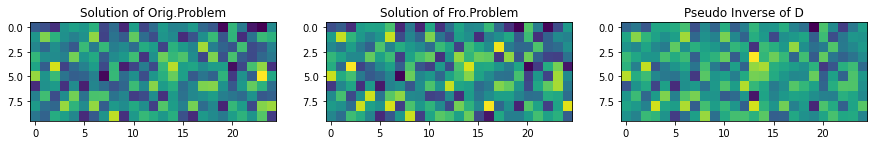

In [7]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_orig.value)
ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_up.value)
ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(D_pinv)
ax[2].set_title('Pseudo Inverse of D')

Constraints:

Text(0.5, 1.0, 'Pseudo Inverse of D')

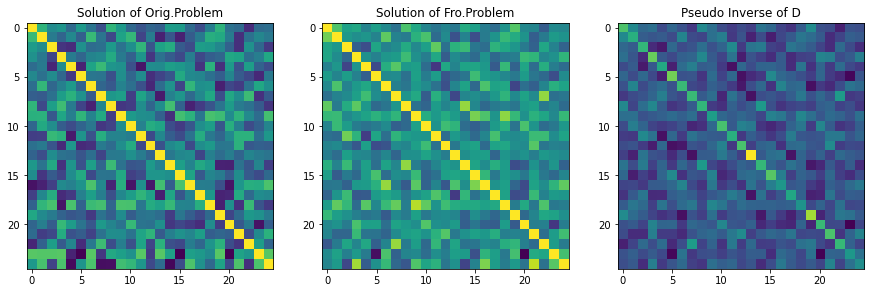

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_orig.value.T@D)
ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_up.value.T@D)
ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(D_pinv.T@D)
ax[2].set_title('Pseudo Inverse of D')

In [ ]:
np.diag(B_orig.value.T@D)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
np.diag(B_up.value.T@D)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
np.diag(D_pinv.T@D)

array([0.44556118, 0.36035868, 0.39195   , 0.49103462, 0.33568795,
       0.50908135, 0.40549678, 0.40594167, 0.38688696, 0.29207437,
       0.43505605, 0.35989136, 0.4404364 , 0.70970619, 0.39602649,
       0.46301131, 0.26745661, 0.33035214, 0.25037892, 0.5792724 ,
       0.40711879, 0.44330955, 0.39707073, 0.26644776, 0.23039172])

Scaling the Pseudo Inverse of $D$ appropriately yields the desired solution!

In [ ]:
d = 1/np.diag(D_pinv.T@D)
B_pinv_mod = D_pinv@np.diag(d)

Text(0.5, 1.0, 'Constraints')

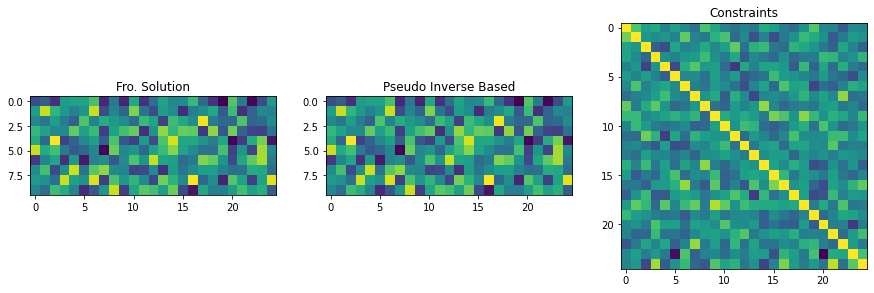

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_up.value)
ax[0].set_title('Fro. Solution')
ax[1].imshow(B_pinv_mod)
ax[1].set_title('Pseudo Inverse Based')
ax[2].imshow(B_pinv_mod.T@D)
ax[2].set_title('Constraints')

Error w.r.t Frobenius Norm Solution

In [ ]:
np.linalg.norm(B_pinv_mod - B_up.value)

3.6185189155820538e-09

In [ ]:
np.linalg.norm(B_pinv_mod - B_orig.value)

2.1122476918055195

In [ ]:
print('Frobenius Norm B_orig = '+str(np.linalg.norm(B_orig.value.T@D, 'fro')))
print('Frobenius Norm B_up = '+str(np.linalg.norm(B_up.value.T@D, 'fro')))
print('Frobenius Norm B_pinv_mod = '+str(np.linalg.norm(B_pinv_mod.T@D, 'fro')))

Frobenius Norm B_orig = 8.570260946821769
Frobenius Norm B_up = 8.169476260742286
Frobenius Norm B_pinv_mod = 8.1694762607418


Conclusion: We can derive the Frobenius Norm Solution via the Pseudo Inverse of $D$

## Case 1.2

Sparse Case, i.e. $d=4$

In [ ]:
d = 4 # number of block length
m = 3 
n = 5 # number of blocks

# creating a random matrix with orthonormal blocks
D = np.zeros((m*d, n*d))
for l in range(0,n):
  D[:,l*d:(l+1)*d] = np.random.normal(size=(m*d, d))
  D[:,l*d:(l+1)*d], _ = np.linalg.qr(D[:,l*d:(l+1)*d])

print('rank(D^T@D)='+str(np.linalg.matrix_rank(D.T@D))) 
print('rank(D@D^T)='+str(np.linalg.matrix_rank(D@D.T)))
print('rank(D)='+str(np.linalg.matrix_rank(D)))
print('coherence = '+str(np.max(np.abs(D.T@D-np.eye(n*d)))))

rank(D^T@D)=12
rank(D@D^T)=12
rank(D)=12
coherence = 0.855694508086884


In [ ]:
B_orig = cvx_orig_solver(D, m, n, d)
B_up = cvx_fro_solver(D, m, n, d)
D_pinv = np.linalg.pinv(D).T

Solutions:

Text(0.5, 1.0, 'Pseudo Inverse of D')

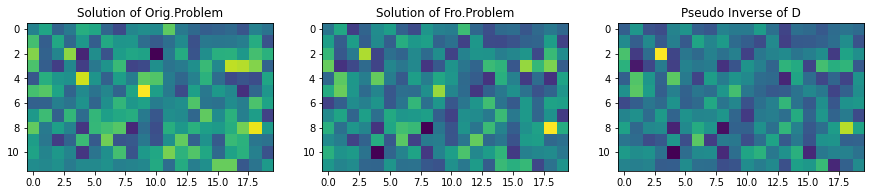

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_orig.value)
ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_up.value)
ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(D_pinv)
ax[2].set_title('Pseudo Inverse of D')

Constraints:

Text(0.5, 1.0, 'Pseudo Inverse of D')

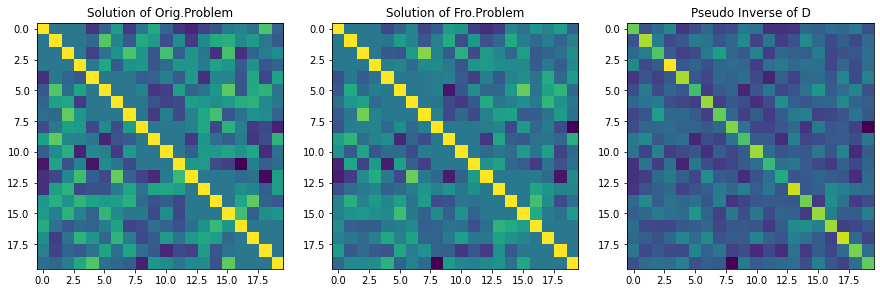

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_orig.value.T@D)
ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_up.value.T@D)
ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(D_pinv.T@D)
ax[2].set_title('Pseudo Inverse of D')

Doing the same steps as above:

In [ ]:
d = 1/np.diag(D_pinv.T@D)
B_pinv_mod = D_pinv@np.diag(d)

Text(0.5, 1.0, 'Constraints for Pseudo Inverse Based')

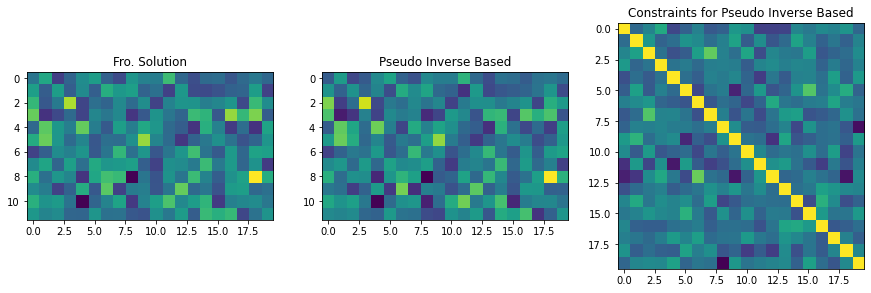

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_up.value)
ax[0].set_title('Fro. Solution')
ax[1].imshow(B_pinv_mod)
ax[1].set_title('Pseudo Inverse Based')
ax[2].imshow(B_pinv_mod.T@D)
ax[2].set_title('Constraints for Pseudo Inverse Based')

Yields a different solution, since we can't met the *orthonormal block* constraints!

Error:

In [ ]:
np.linalg.norm(B_pinv_mod - B_up.value)

1.522578591570065

In [ ]:
np.linalg.norm(B_pinv_mod - B_orig.value)

3.5883300518891743

In [ ]:
print('Frobenius Norm B_orig = '+str(np.linalg.norm(B_orig.value.T@D, 'fro')))
print('Frobenius Norm B_up = '+str(np.linalg.norm(B_up.value.T@D, 'fro')))
print('Frobenius Norm B_pinv_mod = '+str(np.linalg.norm(B_pinv_mod.T@D, 'fro')))

Frobenius Norm B_orig = 6.670062656871873
Frobenius Norm B_up = 6.069694005501626
Frobenius Norm B_pinv_mod = 5.881777861145762


Conclusion: In the general block sparse case, we can't derive the solution via the pseudo inverse of $D$, since we can't met the constraints. 

**Note:** This will not be the case in the MMV case, since here it's sufficient to solve the low dimensional problem, thus the sparse case!

# Case 2

$D\in\mathbb{R}^{m,n}$ with $m>n$

## Case 2.1 

Sparse Case, i.e. $d=1$

In [ ]:
d = 1 # number of block length
m = 25 
n = 10 # number of blocks

# creating a random matrix with orthonormal blocks
D = np.zeros((m*d, n*d))
for l in range(0,n):
  D[:,l*d:(l+1)*d] = np.random.normal(size=(m*d, d))
  D[:,l*d:(l+1)*d], _ = np.linalg.qr(D[:,l*d:(l+1)*d])

print('rank(D^T@D)='+str(np.linalg.matrix_rank(D.T@D))) 
print('rank(D@D^T)='+str(np.linalg.matrix_rank(D@D.T)))
print('rank(D)='+str(np.linalg.matrix_rank(D)))
print('coherence = '+str(np.max(np.abs(D.T@D-np.eye(n*d)))))

rank(D^T@D)=10
rank(D@D^T)=10
rank(D)=10
coherence = 0.46837088808478927


In [ ]:
B_orig = cvx_orig_solver(D, m, n, d)
B_up = cvx_fro_solver(D, m, n, d)
D_pinv = np.linalg.pinv(D).T

Solutions:

Text(0.5, 1.0, 'Pseudo Inverse of D')

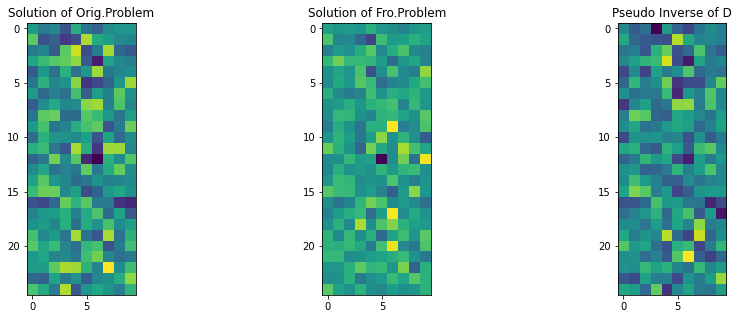

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_orig.value)
ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_up.value)
ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(D_pinv)
ax[2].set_title('Pseudo Inverse of D')

Constraints

Text(0.5, 1.0, 'Pseudo Inverse of D')

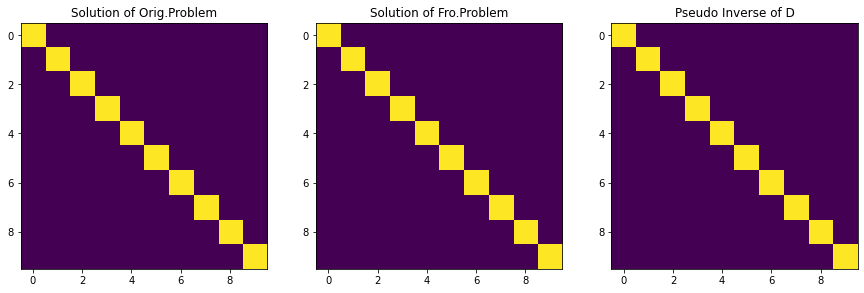

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_orig.value.T@D)
ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_up.value.T@D)
ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(D_pinv.T@D)
ax[2].set_title('Pseudo Inverse of D')

In [ ]:
print('Frobenius Norm B_orig = '+str(np.linalg.norm(B_orig.value.T@D, 'fro')))
print('Frobenius Norm B_up = '+str(np.linalg.norm(B_up.value.T@D, 'fro')))
print('Frobenius Norm B_pinv_mod = '+str(np.linalg.norm(D_pinv.T@D, 'fro')))

Frobenius Norm B_orig = 3.1622776601683795
Frobenius Norm B_up = 3.162277660168456
Frobenius Norm B_pinv_mod = 3.1622776601683804


Conclusion: In this case every solution coincides!

# Case 2.2

In [ ]:
d = 4 # number of block length
m = 5 
n = 3 # number of blocks

# creating a random matrix with orthonormal blocks
D = np.zeros((m*d, n*d))
for l in range(0,n):
  D[:,l*d:(l+1)*d] = np.random.normal(size=(m*d, d))
  D[:,l*d:(l+1)*d], _ = np.linalg.qr(D[:,l*d:(l+1)*d])

print('rank(D^T@D)='+str(np.linalg.matrix_rank(D.T@D))) 
print('rank(D@D^T)='+str(np.linalg.matrix_rank(D@D.T)))
print('rank(D)='+str(np.linalg.matrix_rank(D)))
print('coherence = '+str(np.max(np.abs(D.T@D-np.eye(n*d)))))

rank(D^T@D)=12
rank(D@D^T)=12
rank(D)=12
coherence = 0.6104979935251421


In [ ]:
B_orig = cvx_orig_solver(D, m, n, d)
B_up = cvx_fro_solver(D, m, n, d)
D_pinv = np.linalg.pinv(D).T

Solutions

Text(0.5, 1.0, 'Pseudo Inverse of D')

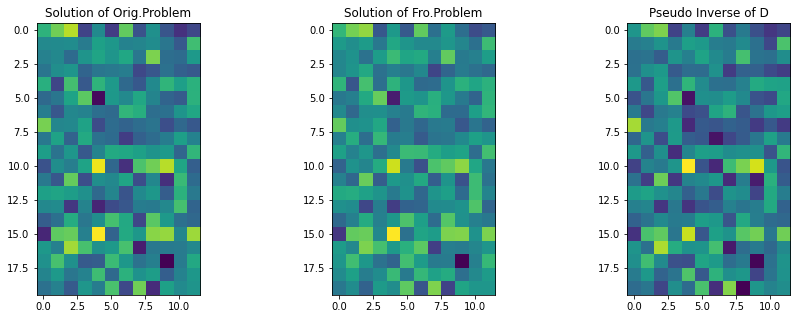

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_orig.value)
ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_up.value)
ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(D_pinv)
ax[2].set_title('Pseudo Inverse of D')

Constraints

Text(0.5, 1.0, 'Pseudo Inverse of D')

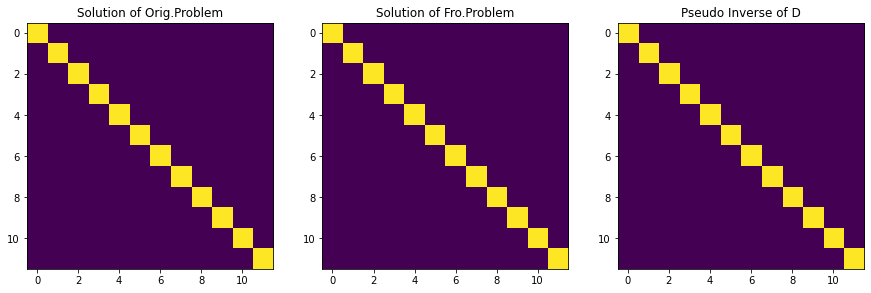

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_orig.value.T@D)
ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_up.value.T@D)
ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(D_pinv.T@D)
ax[2].set_title('Pseudo Inverse of D')

In [ ]:
print('Frobenius Norm B_orig = '+str(np.linalg.norm(B_orig.value.T@D, 'fro')))
print('Frobenius Norm B_up = '+str(np.linalg.norm(B_up.value.T@D, 'fro')))
print('Frobenius Norm B_pinv_mod = '+str(np.linalg.norm(D_pinv.T@D, 'fro')))

Frobenius Norm B_orig = 3.4641015119544534
Frobenius Norm B_up = 3.464101615137756
Frobenius Norm B_pinv_mod = 3.464101615137756


Conclusion: As expected, see conclusion Case 2.1.

In [ ]:
from scipy.linalg import block_diag

In [ ]:

d = 1 # number of block length
m = 10 
n = 25 # number of blocks

# creating a random matrix with orthonormal blocks
D = np.zeros((m*d, n*d))
# for l in range(0,n):
#   D[:,l*d:(l+1)*d] = np.random.normal(size=(m*d, d))
#   D[:,l*d:(l+1)*d], _ = np.linalg.qr(D[:,l*d:(l+1)*d])
D_ = []
B_ = []
B_thm_ = []

for k in range(0,3):
  D = np.zeros((m*d, n*d))
  for l in range(0,n):
    D[:,l*d:(l+1)*d] = np.random.normal(size=(m*d, d))
    D[:,l*d:(l+1)*d], _ = np.linalg.qr(D[:,l*d:(l+1)*d])
    B = cvx_fro_solver(D, m, n, d).value
    B_thm = compute_W_Thm(D, n, d)
  D_.append(D)
  B_.append(B)
  B_thm_.append(B_thm)

In [ ]:
# Create MMV Matrix D_big

def create_mmv_D(D, d):
  
  D_big = np.zeros(((D[0].shape)[0]*3,(D[0].shape)[1]*3))
  a_ = np.zeros(d)
  for i in range((D[0].shape)[0]):
    for j in range((D[0].shape)[1]):
      for k in range(d):
        a_[k] = D[k][i,j]
      # pdb.set_trace()
      D_big[d*i:d*(i+1), d*j:d*(j+1)] = a_*np.eye(d)
  return D_big


In [ ]:
D_big = create_mmv_D(D_, 3)
B_big = create_mmv_D(B_, 3)
B_big_thm = create_mmv_D(B_thm_, 3)

In [ ]:
B_orig = cvx_orig_solver(D_big, m*3, n*3, d)
B_up = cvx_fro_solver(D_big, m, n, 3)
D_pinv = np.linalg.pinv(D_big).T

Text(0.5, 1.0, 'Pseudo Inverse of D')

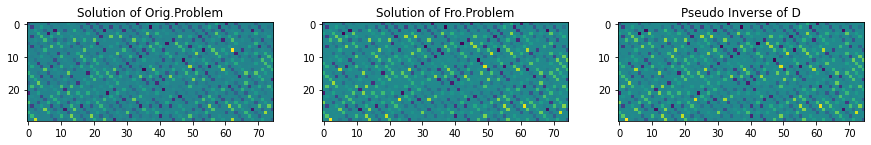

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_orig.value)
ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_big_thm)
ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(B_big)
ax[2].set_title('Pseudo Inverse of D')

Text(0.5, 1.0, 'Pseudo Inverse of D')

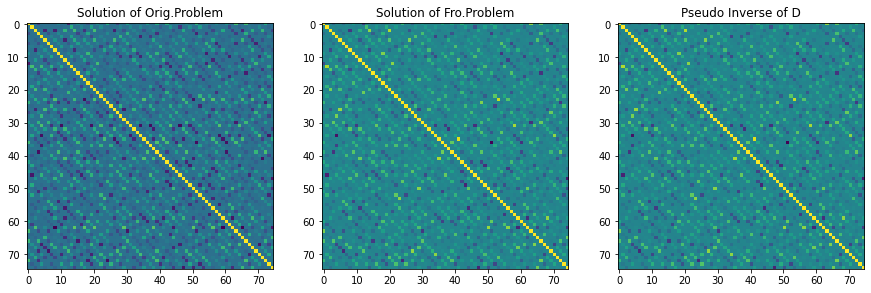

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_orig.value.T@D_big)
ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_big_thm.T@D_big)
ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(B_big.T@D_big)
ax[2].set_title('Pseudo Inverse of D')

In [ ]:

print('Frobenius Norm B_orig = '+str(np.linalg.norm(B_orig.value.T@D_big, 'fro')))
print('Frobenius Norm B_up = '+str(np.linalg.norm(B_big_thm.T@D_big, 'fro')))
print('Frobenius Norm B_pinv_mod = '+str(np.linalg.norm(B_big.T@D_big, 'fro')))

Frobenius Norm B_orig = 14.510518190628835
Frobenius Norm B_up = 13.956497315387013
Frobenius Norm B_pinv_mod = 13.956497315387658


In [ ]:
np.linalg.norm(B_big_thm - B_big, 'fro')

3.5371978763618932e-09

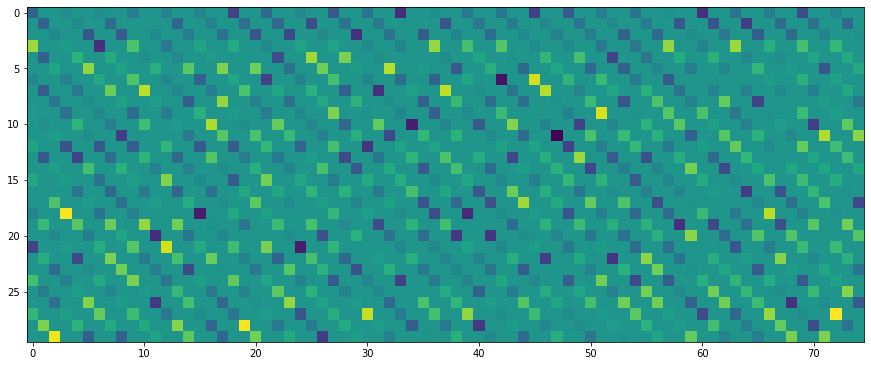

In [ ]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(D_big)

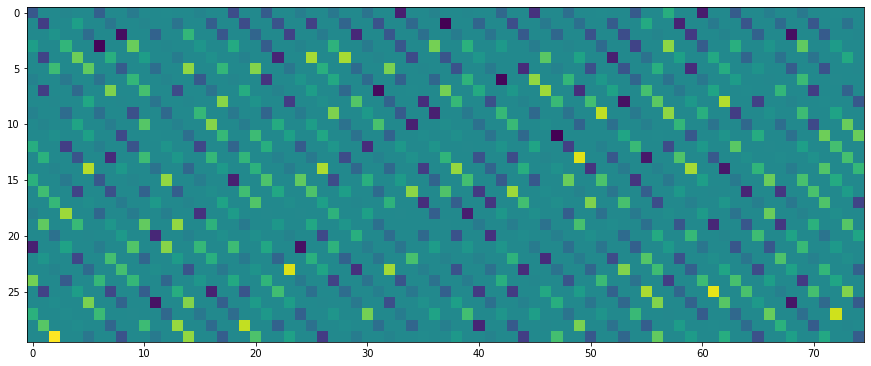

In [ ]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(B_big)

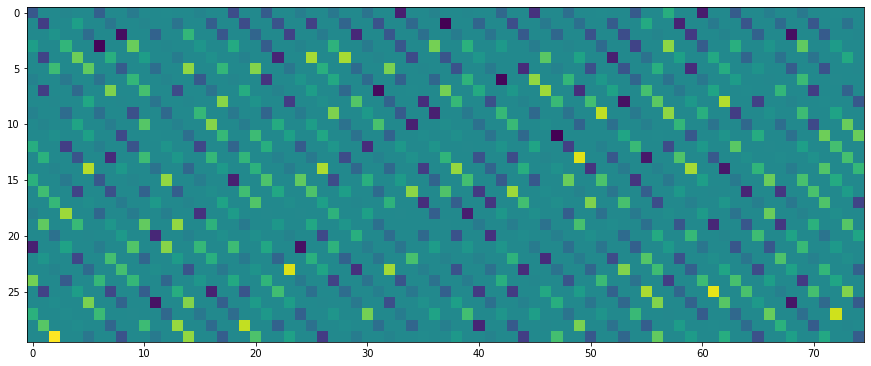

In [ ]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(B_big_thm)

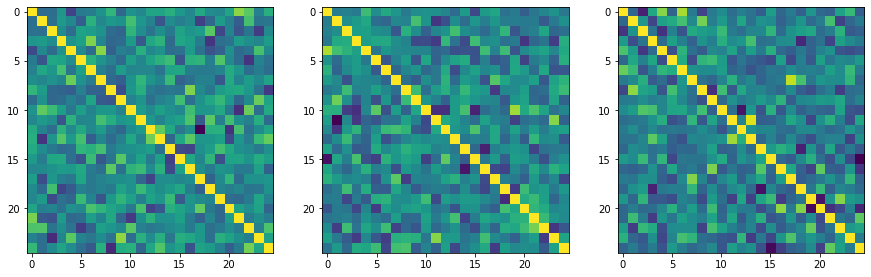

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1,3)
ax[0].imshow(B_thm_[0].T@D_[0])
# ax[0].set_title('Solution of Orig.Problem')
ax[1].imshow(B_thm_[1].T@D_[1])
# ax[1].set_title('Solution of Fro.Problem')
ax[2].imshow(B_thm_[2].T@D_[2])
# ax[2].set_title('Pseudo Inverse of D')